In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

sns.set_theme(style="whitegrid")
plt.rc("text", usetex=True)

In [2]:
def match_dialogue_f_to_book(quotes_f, books_files, prefix="asoif_"):
    query = quotes_f.split(".")[0]
    query = query.replace(prefix, "")

    for book_f in books_files:
        tuned = book_f.split("- ")[1].split(".")[0].replace(" ", "_").lower()

        if query in tuned:
            return book_f

    raise ValueError(f"Could not match {query} to any book")

In [3]:
# Advanced NLP
ignorables = [
    "a",
    "an",
    "the",
    "he",
    "she",
    "it",
    "they",
    "we",
    "you",
    "i",
    "me",
    "him",
    "her",
    "us",
    "them",
    "my",
    "your",
    "his",
    "her",
    "our",
    "their",
    "this",
    "that",
    "these",
    "those",
    "here",
    "there",
    "where",
]

# Preprocessing and clustering


In [25]:
import csv
import string

printable = set(string.printable)


def get_df_for_series(data_dir, books_dir, prefix, debug=False):
    dialogue_files = os.listdir(data_dir)
    books_files = os.listdir(books_dir)
    books_files = list(filter(lambda x: "Book" in x, books_files))
    quotes_files = list(filter(lambda x: "quotes" in x, dialogue_files))

    print(f"books: {', '.join(books_files)}")
    print(f"quotes: {', '.join(quotes_files)}")

    # character name -> { book_name_1: [char_id_1,..., char_id_n], book_name_2: [char_id_1,..., char_id_n] }
    characters_to_ids = {}

    for quotes_f in quotes_files:
        # ['quote_start', 'quote_end', 'mention_start', 'mention_end', 'mention_phrase', 'char_id', 'quote']
        print(f"------------------ Processing {quotes_f}")
        df_q = pd.read_csv(
            os.path.join(data_dir, quotes_f), sep="\t", on_bad_lines="skip", quoting=csv.QUOTE_NONE, encoding="utf-8"
        )
        unique_char_ids = df_q["char_id"].unique()
        characters = []

        for char_id in unique_char_ids:
            df = df_q[df_q["char_id"] == char_id]

            if len(df) < 10:
                continue

            df_q_char = df.groupby("mention_phrase").size().reset_index(name="counts")

            d = {}

            for i, row in df_q_char.iterrows():
                mention_phrase = row["mention_phrase"]
                mention_phrase = "".join(filter(lambda x: x in printable, mention_phrase))
                counts = row["counts"]

                alts = mention_phrase.split(" ")

                for alt in alts:
                    if alt.lower() in ignorables:
                        continue

                    # We don't consider two letter names real names. Sorry Jo
                    if len(alt) < 3:
                        continue

                    if alt in d:
                        d[alt] += counts
                    else:
                        d[alt] = counts

            if 0 == sum(d.values()):
                continue

            sum_of_quotes = len(df)

            max_d = max(d.values())

            # all mentions phrases with the same count
            # solves the issue of actual names with 2 or 3 words. E.g. "Hot Pie" or "Old Bear"
            max_d = [k for k, v in d.items() if v == max_d]

            mention_phrase = " ".join(max_d)

            if debug:
                builder = ""

                for k, v in d.items():
                    builder += f"{k}: {v}, "

                print(f"{mention_phrase}: unique mentions phrases: {builder}")
            characters.append({"char_id": char_id, "name": mention_phrase, "quotes_count": sum_of_quotes})

        df_chars = pd.DataFrame(characters)

        df_chars_grouped = (
            df_chars.groupby("name")
            .agg(quotes_count=("quotes_count", "sum"), char_ids=("char_id", lambda x: list(x)))
            .reset_index()
        )

        print(df_chars_grouped.to_string())

        df_chars_grouped = df_chars_grouped.sort_values(by="quotes_count", ascending=False).reset_index()

        for i, row in df_chars_grouped.iterrows():
            name = row["name"]
            char_ids = row["char_ids"]
            # quotes_count = row["quotes_count"]

            if name in characters_to_ids:
                characters_to_ids[name][quotes_f] = char_ids
            else:
                characters_to_ids[name] = {quotes_f: char_ids}

    for name, books in characters_to_ids.items():
        builder = f"Character {name} appears in: "
        for book, char_ids in books.items():
            book_name = match_dialogue_f_to_book(book, books_files, prefix=prefix)
            builder += f"{book_name} (ids: {', '.join([str(x) for x in char_ids])}), "

        print(builder)

    main_df = pd.DataFrame()

    for character_name, books in characters_to_ids.items():
        for book, char_ids in books.items():
            quotes_file = os.path.join(data_dir, book)

            df = pd.read_csv(quotes_file, sep="\t", on_bad_lines="skip", quoting=csv.QUOTE_NONE, encoding="utf-8")

            df = df[df["char_id"].isin(char_ids)]
            df = df.drop(columns=["mention_start", "mention_phrase", "char_id"])
            df["Character"] = character_name
            df["Book"] = match_dialogue_f_to_book(book, books_files, prefix=prefix)
            df["Quotes"] = book
            main_df = pd.concat([main_df, df])

    return main_df


asoif_dir = "../dialogue/inter/asoif"
asoif_books = "../books/asoif"
hp_dir = "../dialogue/inter/hp"
hp_books = "../books/hp"

df_asoif = get_df_for_series(asoif_dir, asoif_books, debug=True, prefix="asoif_")
df_hp = get_df_for_series(hp_dir, hp_books, debug=True, prefix="hp_")

books: Book 2 - A Clash of Kings.txt, Book 3 - A Storm of Swords.txt, Book 1 - A Game of Thrones.txt, Book 5 - A Dance With Dragons.txt, Book 4 - A Feast for Crows.txt
quotes: asoif_a_clash_of_kings.quotes, asoif_a_storm_of_swords.quotes, asoif_a_game_of_thrones.quotes, asoif_a_dance_with_dragons.quotes, asoif_a_feast_for_crows.quotes
------------------ Processing asoif_a_clash_of_kings.quotes
Pylos: unique mentions phrases: Maester: 2, Pylos: 11, 
old man: unique mentions phrases: old: 23, man: 23, himself: 3, 
Cressen: unique mentions phrases: Cressen: 35, Maester: 7, 
fool: unique mentions phrases: fool: 8, 
maester: unique mentions phrases: maester: 60, himself: 1, 
Patchface: unique mentions phrases: Patchface: 7, 
Davos: unique mentions phrases: Davos: 85, Ser: 1, himself: 1, 
man: unique mentions phrases: man: 23, himself: 1, 
Stannis: unique mentions phrases: Lord: 10, Stannis: 37, Baratheon: 3, 
Renly: unique mentions phrases: Renly: 64, 
Stannis: unique mentions phrases: Stan

In [26]:
df_asoif.head()

,quote_start,quote_end,mention_end,quote,Character,Book,Quotes
405,20968,20977,20978,"“ We share that view , sweet child . ”",Tyrion,Book 2 - A Clash of Kings.txt,asoif_a_clash_of_kings.quotes
406,20983,21001,20978,"“ My lady , I am sorry for your losses . Truly...",Tyrion,Book 2 - A Clash of Kings.txt,asoif_a_clash_of_kings.quotes
408,21059,21063,21024,“ What loss ? ”,Tyrion,Book 2 - A Clash of Kings.txt,asoif_a_clash_of_kings.quotes
409,21064,21092,21024,“ Your royal father ? A large fierce man with ...,Tyrion,Book 2 - A Clash of Kings.txt,asoif_a_clash_of_kings.quotes
410,21093,21110,21024,"“ Oh , him . Yes , it was very sad , a boar ki...",Tyrion,Book 2 - A Clash of Kings.txt,asoif_a_clash_of_kings.quotes


In [27]:
display(df_asoif["Character"].value_counts().sort_values(ascending=False).head(10))
display(df_hp["Character"].value_counts().sort_values(ascending=False).head(10))

Character
Tyrion     2613
Jon        1913
Dany       1237
Jaime      1014
Arya        919
Brienne     887
Catelyn     885
Cersei      845
Sansa       703
Bran        680
Name: count, dtype: int64

Character
Harry          8130
Ron            4292
Hermione       3810
Dumbledore     1782
Hagrid         1414
Snape           881
Lupin           641
Fred            593
Mr. Weasley     540
Malfoy          469
Name: count, dtype: int64

# Visualization


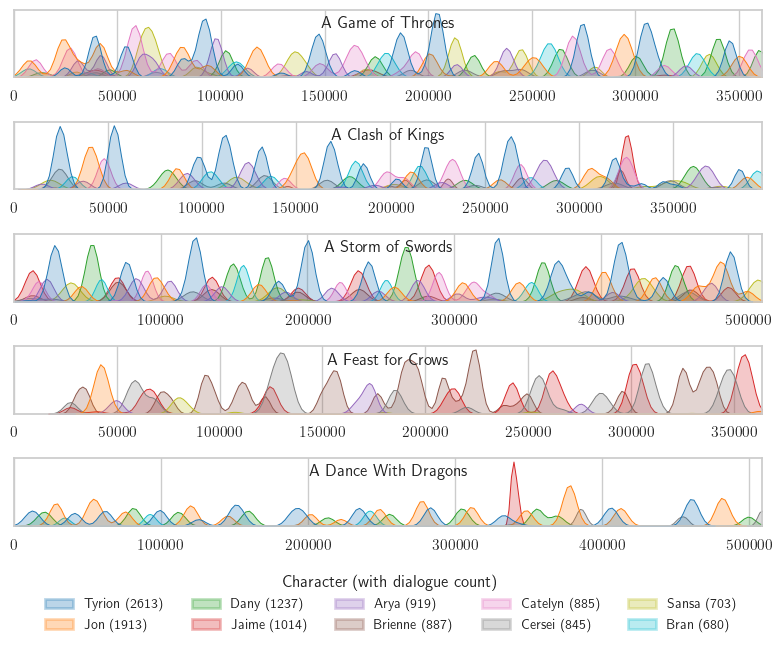

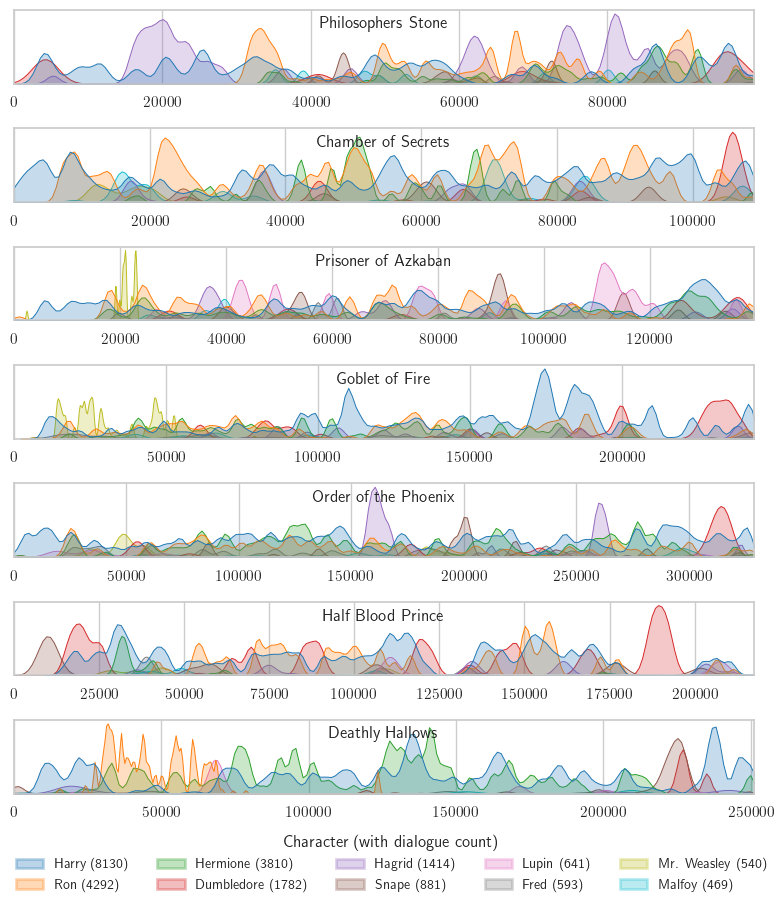

In [28]:
def create_plot(df_main, bottom, filename=None):
    characters_top_10 = df_main["Character"].value_counts().sort_values(ascending=False).head(10).index.tolist()

    unique_books = df_main["Book"].unique().tolist()

    fig, axs = plt.subplots(len(unique_books), 1, figsize=(8, len(unique_books) * 1.3))

    # sort by name of the book
    unique_books = sorted(unique_books)

    # Create a color palette
    palette = sns.color_palette("tab10", len(characters_top_10))

    # Create a dictionary mapping each character to a color
    character_colors = dict(zip(characters_top_10, palette))

    for ax, book in zip(axs, unique_books):
        df = df_main[df_main["Book"] == book]
        df = df[df["Character"].isin(characters_top_10)]
        df["Len of quote"] = df["quote"].apply(lambda x: np.log(len(x.split(" "))))

        ax.set_xlim(0, df["quote_start"].max())
        sns.kdeplot(
            data=df,
            x="quote_start",
            weights="Len of quote",
            hue="Character",
            ax=ax,
            fill=True,
            # multiple='stack',
            common_norm=True,
            # alpha=0.3,
            linewidth=0.7,
            palette=character_colors,  # Use the predefined color palette
            bw_adjust=0.10,
        )

        book_name = "  " + book.split("- ")[1].split(".")[0]

        # black background for the text
        ax.text(
            0.50,
            0.90,
            book_name,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.transAxes,
            fontsize=12,
        )

        ax.yaxis.set_visible(False)
        ax.set_xlabel("")
        ax.get_legend().remove()

    legend_elements = [
        Patch(
            facecolor=color,
            linewidth=2,
            alpha=0.3,
            in_layout=True,
            edgecolor=color,
            label=f"{character} ({len(df_main[df_main['Character'] == character])})",
        )
        for character, color in character_colors.items()
    ]

    fig.legend(
        handles=legend_elements,
        loc="lower center",
        ncol=5,
        title="Character (with dialogue count)",
        prop={"size": 10},
        frameon=False,
    )

    plt.tight_layout(rect=[0, bottom, 1, 1])
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()


# create_plot(df_asoif, bottom=0.11, filename="asoif_dialogue.pdf")
# create_plot(df_hp, bottom=0.07, filename="hp_dialogue.pdf")
create_plot(df_asoif, bottom=0.11)
create_plot(df_hp, bottom=0.07)

In [29]:
print(f"Len of asoif: {len(df_asoif)}, len of hp: {len(df_hp)}")
print(f"Total len: {len(df_asoif) + len(df_hp)}")

Len of asoif: 36946, len of hp: 32541
Total len: 69487


# Export

Export to `dialogue.csv` format. Should be like this:

- `series`: `hp` or `asoiaf`
- `book`: book name
- `character`: character name
- `context`: The first 3 sentences before the dialogue
- `prev_context`: The 3 sentences before the context
- `prev_prev_context`: The 3 sentences before the prev_context
- `dialogue`: dialogue / quote

The point of having 3 by 3 contextes is for evaluation purposes. We can test if giving more context to the model helps it to generate better dialogues / reason about the context better. When evaluating, just join the 3 contextes with a space.


In [105]:
import string

printable = set(string.printable)


def get_tokens_dir(series: str):
    return f"../dialogue/inter/{series}"


def remove_non_printable(text: str) -> str:
    return "".join(filter(lambda x: x in printable, text))


def get_x_sentences(list_df, token_index, num_of_sent) -> tuple[str, int, int]:
    token_index -= 1

    if token_index <= 0:
        return "", token_index

    current_sentence_id = list_df[token_index][0]
    tokens = []

    while num_of_sent > 0:
        (sent_id, token, pos) = list_df[token_index]

        if sent_id != current_sentence_id:
            num_of_sent -= 1
            current_sentence_id = sent_id

            if num_of_sent == 0:
                break

        if pos == "PUNCT":
            tokens.append(str(token))
        else:
            tokens.append(" " + str(token))

        token_index -= 1

        if token_index < 0:
            break

    sentence = "".join(tokens[::-1])

    return sentence, token_index + 1


def get_context(list_df, pos) -> list[str]:
    context = []

    for _ in range(3):
        sentences, pos = get_x_sentences(list_df, pos, 3)
        context.append(sentences)

    context = context[::-1]  # reverse the list

    return context


def extract_dialog_file(series: str, df: pd.DataFrame):
    books = df["Book"].unique().tolist()
    characters = df["Character"].unique().tolist()

    print(f"Found {len(books)} books and {len(characters)} characters in {series}. Total of {len(df)} quotes")

    df_builder = []

    tokens_dir = get_tokens_dir(series)

    for book in books:
        print(f"Book: {book}")

        # find first row of the book
        df_book = df[df["Book"] == book].iloc[0]
        quotes = df_book["Quotes"]

        tokens = tokens_dir + "/" + quotes.split(".")[0] + ".tokens"

        df_tokens = pd.read_csv(tokens, sep="\t", quoting=csv.QUOTE_NONE, encoding="utf-8")[
            ["sentence_ID", "word", "POS_tag"]
        ]

        list_tokens = list(df_tokens.itertuples(index=False))

        print(f"Len of tokens: {len(df_tokens)}")

        book_name = book.split("- ")[1].split(".")[0]

        for character in characters:
            df_char = df[(df["Book"] == book) & (df["Character"] == character)]

            for i, row in df_char.iterrows():
                start = row["quote_start"]
                end = row["quote_end"]

                quote_tokens = list_tokens[start:end]

                quote = ""

                for _, token, pos in quote_tokens:
                    if pos == "PUNCT":
                        quote += str(token)
                    else:
                        quote += " " + str(token)

                quote = quote.lstrip("“").rstrip("”").strip()

                (prev_prev, prev, context) = get_context(list_tokens, start)

                # print(f"Prev prev context: {prev_prev}")
                # print(f"Prev context: {prev}")
                # print(f"Context: {context}")
                # print(f"Quote: {quote}")

                df_builder.append(
                    {
                        "series": series,
                        "book": book_name,
                        "character": character,
                        "prev_prev_context": prev_prev,
                        "prev_context": prev,
                        "context": context,
                        "dialogue": quote,
                    }
                )

    df_final = pd.DataFrame(df_builder)

    return df_final


df_hp_fin = extract_dialog_file("hp", df_hp)
df_asoif_fin = extract_dialog_file("asoif", df_asoif)

print(f"Len of hp: {len(df_hp_fin)}, len of asoif: {len(df_asoif_fin)}")

df_final = pd.concat([df_hp_fin, df_asoif_fin])

print(f"Len of final: {len(df_final)}")

df_final.to_csv("../dialogue/booknlp.csv", index=False)

Found 7 books and 148 characters in hp. Total of 32541 quotes
Book: Book 3 - Prisoner of Azkaban.txt
Len of tokens: 139862
Book: Book 5 - Order of the Phoenix.txt
Len of tokens: 329268
Book: Book 4 - Goblet of Fire.txt
Len of tokens: 243407
Book: Book 1 - Philosophers Stone.txt
Len of tokens: 99816
Book: Book 6 - Half Blood Prince.txt
Len of tokens: 218256
Book: Book 7 - Deathly Hallows.txt
Len of tokens: 251107
Book: Book 2 - Chamber of Secrets.txt
Len of tokens: 109073
Found 5 books and 448 characters in asoif. Total of 36946 quotes
Book: Book 2 - A Clash of Kings.txt
Len of tokens: 405007
Book: Book 3 - A Storm of Swords.txt
Len of tokens: 527559
Book: Book 1 - A Game of Thrones.txt
Len of tokens: 367148
Book: Book 5 - A Dance With Dragons.txt
Len of tokens: 523602
Book: Book 4 - A Feast for Crows.txt
Len of tokens: 381855
Len of hp: 32541, len of asoif: 36946
Len of final: 69487
